In [13]:
from torch import no_grad, tensor
from torch.nn import LSTM, Linear, Module, MSELoss
from torch.optim import Adam
from torch.utils.data import DataLoader, TensorDataset

from pandas import read_csv, DataFrame, Series
from dslabs_functions import series_train_test_split, HEIGHT, plot_multiline_chart, FORECAST_MEASURES, DELTA_IMPROVE, plot_forecasting_eval, plot_forecasting_series
from copy import deepcopy
from matplotlib.pyplot import figure, savefig, subplots


In [14]:
def prepare_dataset_for_lstm(series, seq_length: int = 4):
    setX: list = []
    setY: list = []
    for i in range(len(series) - seq_length):
        past = series[i : i + seq_length]
        future = series[i + 1 : i + seq_length + 1]
        setX.append(past)
        setY.append(future)
    return tensor(setX), tensor(setY)


class DS_LSTM(Module):
    def __init__(self, train, input_size: int = 1, hidden_size: int = 50, num_layers: int = 1, length: int = 4, lr:float = 0.001):
        super().__init__()
        self.lstm = LSTM(input_size=input_size, hidden_size=hidden_size, num_layers=num_layers, batch_first=True)
        self.linear = Linear(hidden_size, 1)
        self.optimizer = Adam(self.parameters(), lr)
        self.loss_fn = MSELoss()

        trnX, trnY = prepare_dataset_for_lstm(train, seq_length=length)
        self.loader = DataLoader(TensorDataset(trnX, trnY), shuffle=True, batch_size=len(train) // 10)

    def forward(self, x):
        x, _ = self.lstm(x)
        x = self.linear(x)
        return x

    def fit(self):
        self.train()
        for batchX, batchY in self.loader:
            y_pred = self(batchX)
            loss = self.loss_fn(y_pred, batchY)
            self.optimizer.zero_grad()
            loss.backward()
            self.optimizer.step()
        return loss

    def predict(self, X):
        with no_grad():
            y_pred = self(X)
        return y_pred[:, -1, :]

In [15]:
filename: str = "datasets/forecasting_covid_transformed.csv"
file_tag: str = "forecasting_covid_evaluation"
target: str = "deaths"
timecol: str = "date"
measure: str = "MAPE"

data: DataFrame = read_csv(filename, index_col=timecol, sep=",", decimal=".", parse_dates=True)
series = data[[target]].values.astype("float32")

train_size = int(len(series) * 0.90)
train, test = series[:train_size], series[train_size:]

In [16]:
model = DS_LSTM(train, input_size=4, hidden_size=50, num_layers=1, length=4)
loss = model.fit()
print(loss)

tensor(9.9211e+11, grad_fn=<MseLossBackward0>)


seq length=2 hidden_units=25 nr_episodes=0 0.9999942
seq length=2 hidden_units=25 nr_episodes=10000 0.9424105
seq length=2 hidden_units=25 nr_episodes=20000 0.884852
seq length=2 hidden_units=25 nr_episodes=30000 0.8273235
seq length=2 hidden_units=25 nr_episodes=40000 0.76984656
seq length=2 hidden_units=25 nr_episodes=50000 0.7124443
seq length=2 hidden_units=25 nr_episodes=60000 0.65511936
seq length=2 hidden_units=25 nr_episodes=70000 0.5975927
seq length=2 hidden_units=25 nr_episodes=80000 0.539935
seq length=2 hidden_units=25 nr_episodes=90000 0.48275697
seq length=2 hidden_units=25 nr_episodes=100000 0.42621613
seq length=2 hidden_units=50 nr_episodes=0 0.9999869
seq length=2 hidden_units=50 nr_episodes=10000 0.86809605
seq length=2 hidden_units=50 nr_episodes=20000 0.73641086
seq length=2 hidden_units=50 nr_episodes=30000 0.6050986
seq length=2 hidden_units=50 nr_episodes=40000 0.47467107
seq length=2 hidden_units=50 nr_episodes=50000 0.34698957
seq length=2 hidden_units=50 nr_

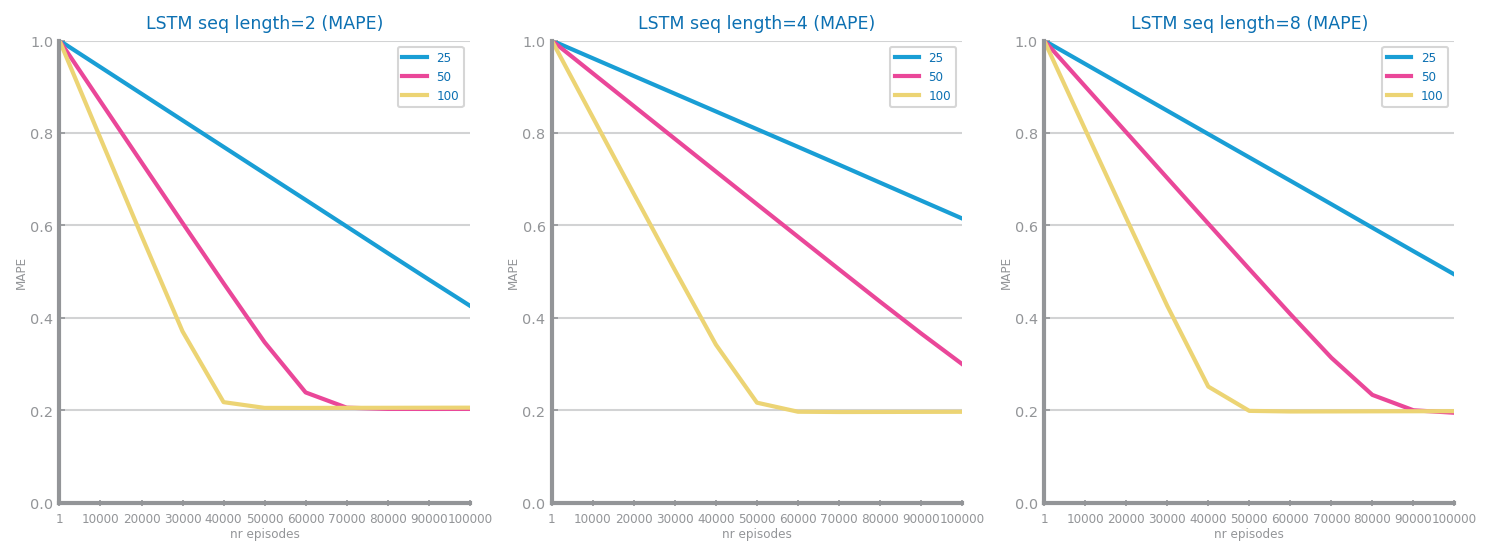

In [23]:
def lstm_study(train, test, nr_episodes: int = 1000, measure: str = "R2", lr:float = 0.001):
    sequence_size = [2, 4, 8]
    nr_hidden_units = [25, 50, 100]

    step: int = nr_episodes // 10
    episodes = [1] + list(range(0, nr_episodes + 1, step))[1:]
    flag = measure == "R2" or measure == "MAPE"
    best_model = None
    best_params: dict = {"name": "LSTM", "metric": measure, "params": ()}
    best_performance: float = -100000

    _, axs = subplots(1, len(sequence_size), figsize=(len(sequence_size) * HEIGHT, HEIGHT))

    for i in range(len(sequence_size)):
        length = sequence_size[i]
        tstX, tstY = prepare_dataset_for_lstm(test, seq_length=length)

        values = {}
        for hidden in nr_hidden_units:
            yvalues = []
            model = DS_LSTM(train, hidden_size=hidden, lr=lr)
            for n in range(0, nr_episodes + 1):
                model.fit()
                if n % step == 0:
                    prd_tst = model.predict(tstX)
                    eval: float = FORECAST_MEASURES[measure](test[length:], prd_tst)
                    print(f"seq length={length} hidden_units={hidden} nr_episodes={n}", eval)
                    better_performance:bool = (eval > best_performance and measure == "R2") or eval < best_performance
                    if best_model == None or (better_performance and abs(eval - best_performance) > DELTA_IMPROVE):
                        best_performance: float = eval
                        best_params["params"] = (length, hidden, n)
                        best_model = deepcopy(model)
                    yvalues.append(eval)
            values[hidden] = yvalues
        plot_multiline_chart(
            episodes,
            values,
            ax=axs[i],
            title=f"LSTM seq length={length} ({measure})",
            xlabel="nr episodes",
            ylabel=measure,
            percentage=flag,
        )
    
    savefig(f"images/forecast/modeling/{file_tag}_lstms_{measure}.png")
    print(
        f"LSTM best results achieved with length={best_params['params'][0]} hidden_units={best_params['params'][1]} and nr_episodes={best_params['params'][2]}) ==> measure={best_performance:.2f}"
    )
    return best_model, best_params


best_model, best_params = lstm_study(train, test, nr_episodes=100000, measure=measure, lr=0.1)

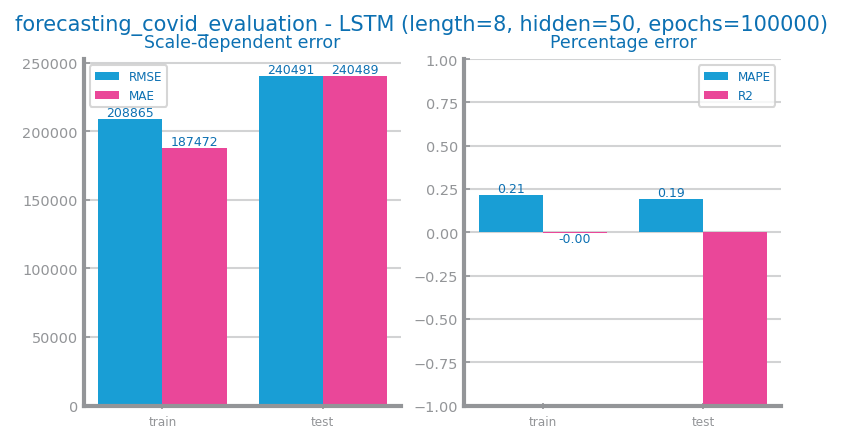

In [24]:
params = best_params["params"]
best_length = params[0]
trnX, trnY = prepare_dataset_for_lstm(train, seq_length=best_length)
tstX, tstY = prepare_dataset_for_lstm(test, seq_length=best_length)

prd_trn = best_model.predict(trnX)
prd_tst = best_model.predict(tstX)

plot_forecasting_eval(
    train[best_length:],
    test[best_length:],
    prd_trn,
    prd_tst,
    title=f"{file_tag} - LSTM (length={best_length}, hidden={params[1]}, epochs={params[2]})",
)
savefig(f"images/forecast/modeling/{file_tag}_lstms_{measure}_eval.png")

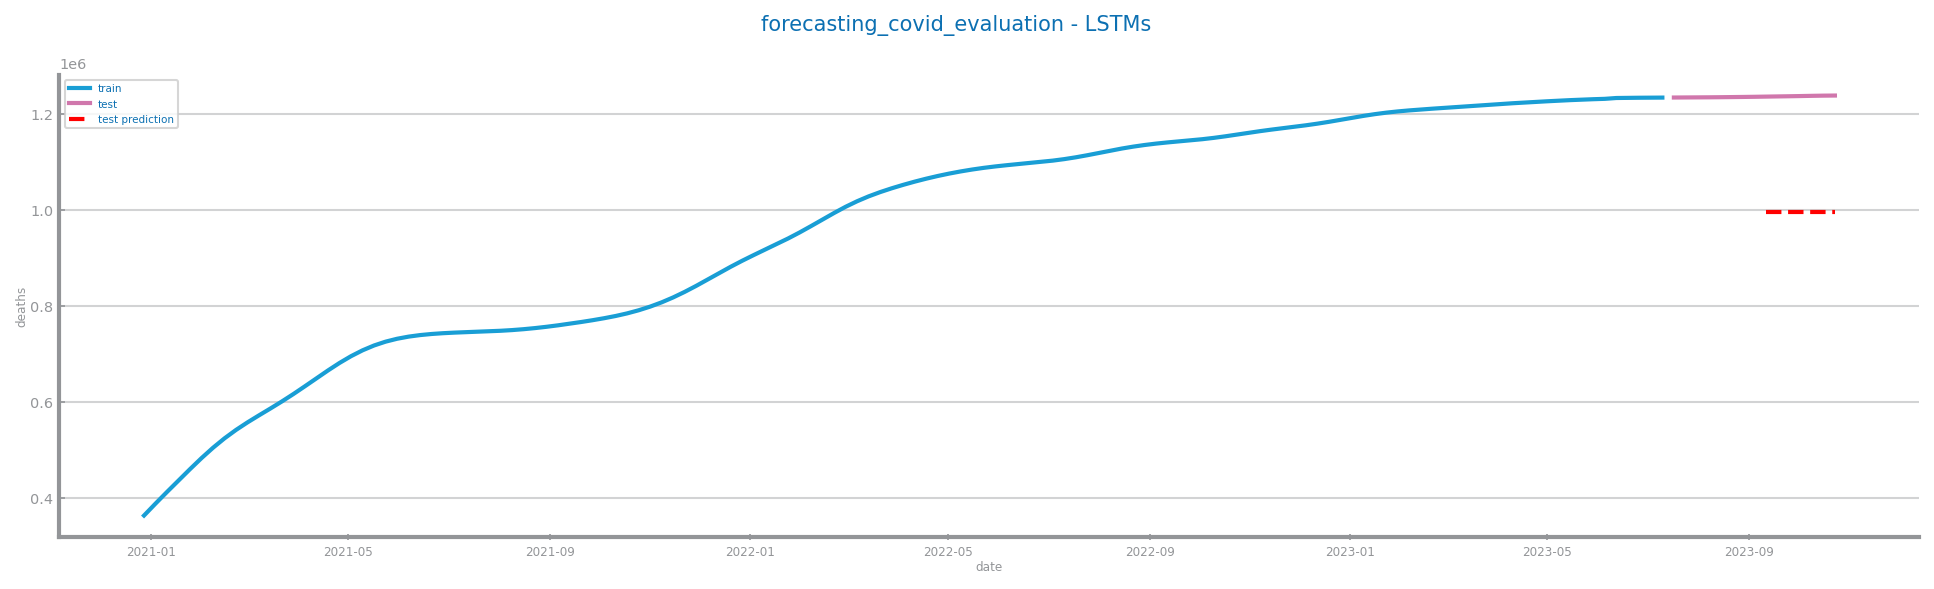

In [27]:
series = data[[target]]
train, test = series[:train_size], series[train_size:]
pred_series: Series = Series(prd_tst.numpy().ravel(), index=test.index[best_length:])

plot_forecasting_series(
    train[best_length:],
    test[best_length:],
    pred_series,
    title=f"{file_tag} - LSTMs ",
    xlabel=timecol,
    ylabel=target,
)
savefig(f"images/forecast/modeling/{file_tag}_lstms_{measure}_forecast.png")